In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('../data/retail_store_data_with_real_items.csv')
df.head()

,Date,Day,Item Name,Price,In Stock,Total Stock,Sales,Stock Left,Revenue
0,2022-01-01,Saturday,Tea,11.65,True,64,19,45,221.35
1,2022-01-01,Saturday,Shaving Cream,36.52,True,78,23,55,839.96
2,2022-01-01,Saturday,All-Purpose Cleaner,13.58,True,109,28,81,380.24
3,2022-01-01,Saturday,Rice,6.30,True,187,14,173,88.20
4,2022-01-01,Saturday,Perfume,43.33,True,137,0,137,0.00


In [6]:
# 2. Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Date           0
Day            0
Item Name      0
Price          0
In Stock       0
Total Stock    0
Sales          0
Stock Left     0
Revenue        0
dtype: int64


In [7]:
df = df.rename(columns={'Sales': 'Sold Item'})

In [8]:
df.head()

,Date,Day,Item Name,Price,In Stock,Total Stock,Sold Item,Stock Left,Revenue
0,2022-01-01,Saturday,Tea,11.65,True,64,19,45,221.35
1,2022-01-01,Saturday,Shaving Cream,36.52,True,78,23,55,839.96
2,2022-01-01,Saturday,All-Purpose Cleaner,13.58,True,109,28,81,380.24
3,2022-01-01,Saturday,Rice,6.30,True,187,14,173,88.20
4,2022-01-01,Saturday,Perfume,43.33,True,137,0,137,0.00


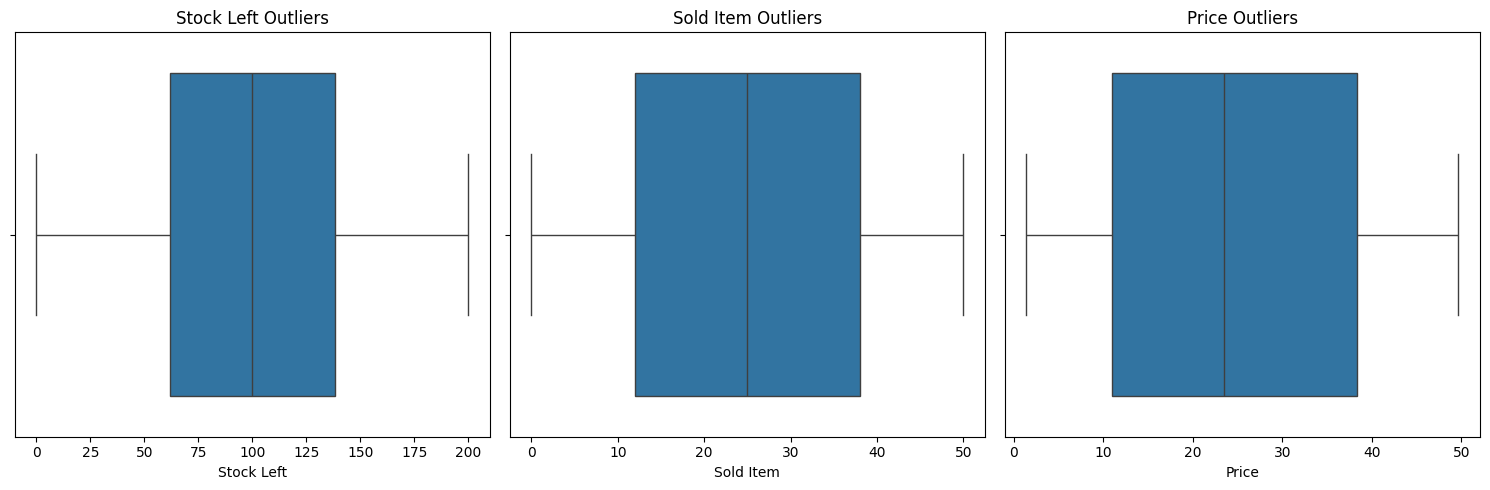

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Visualize data to check for outliers
# Plot boxplots for 'Stock Left', 'Sold Item', and 'Price'
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x=df['Stock Left'])
plt.title('Stock Left Outliers')

plt.subplot(1, 3, 2)
sns.boxplot(x=df['Sold Item'])
plt.title('Sold Item Outliers')

plt.subplot(1, 3, 3)
sns.boxplot(x=df['Price'])
plt.title('Price Outliers')

plt.tight_layout()
plt.show()

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

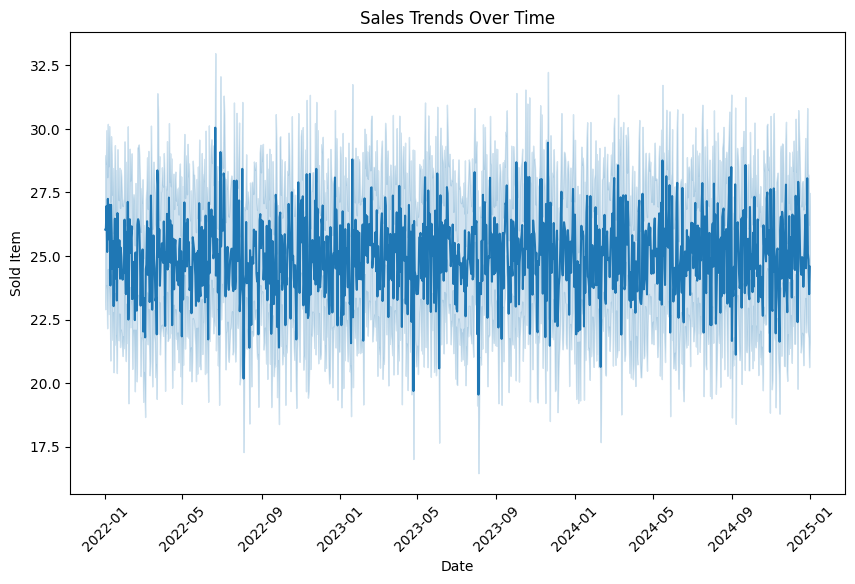

In [11]:
# 1. Sales Trends Over Time
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Date', y='Sold Item')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sold Item')
plt.xticks(rotation=45)
plt.show()

### Arima Model

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

In [16]:
# Aggregate the data by day and sum the 'Units Sold' for daily demand
daily_demand = df.resample('D')['Sold Item'].sum()
daily_demand

Date
2022-01-01    2604
2022-01-02    2610
2022-01-03    2697
2022-01-04    2516
2022-01-05    2725
              ... 
2024-12-27    2806
2024-12-28    2510
2024-12-29    2486
2024-12-30    2350
2024-12-31    2458
Freq: D, Name: Sold Item, Length: 1096, dtype: int64

In [17]:
# 2. Check for Stationarity
# Perform ADF Test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")

adf_test(daily_demand)

ADF Statistic: -32.546935692127626
p-value: 0.0


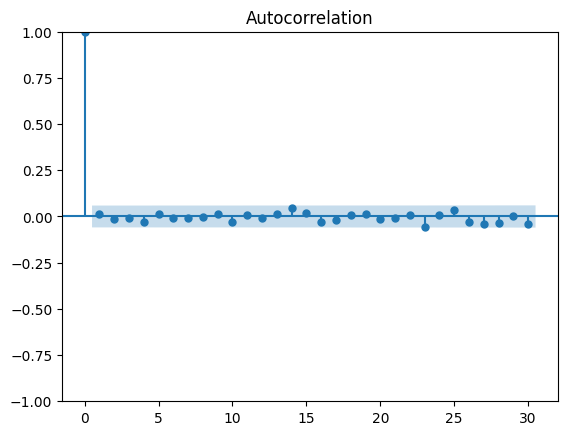

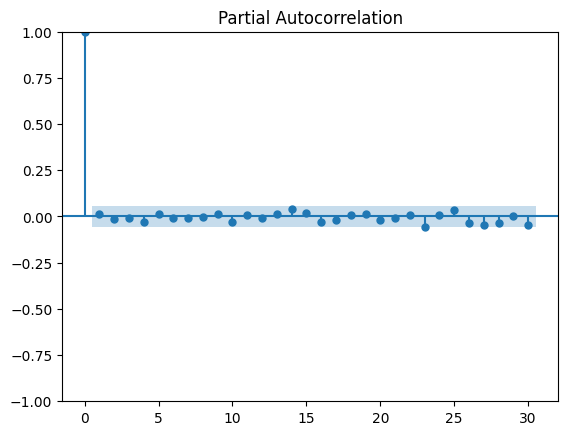

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
plot_acf(daily_demand, lags=30)
plot_pacf(daily_demand, lags=30)
plt.show()


In [18]:
# 3. Model Building (ARIMA)
# Split the data into training and testing sets
train_size = int(len(daily_demand) * 0.8)
train, test = daily_demand[:train_size], daily_demand[train_size:]

In [24]:
# Fit the ARIMA model (p=1, d=1, q=1 as a starting point, can be tuned)
# model = ARIMA(train, order=(1, 1, 1))
# model_fit = model.fit()

import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Define a grid search function
def grid_search_arima(series, p_values, d_values, q_values):
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_model = results
                except:
                    continue
    return best_order, best_model

# Define the range of parameters to search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Perform grid search
best_order, best_model = grid_search_arima(train, p_values, d_values, q_values)
print("Best ARIMA order:", best_order)
print("AIC of best model:", best_model.aic)


Best ARIMA order: (1, 1, 2)
AIC of best model: 11245.719636998401


In [25]:
# 4. Forecasting
forecast = best_model.forecast(steps=len(test))

In [26]:
# 5. Model Evaluation
# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse}")

RMSE: 154.40520595049142


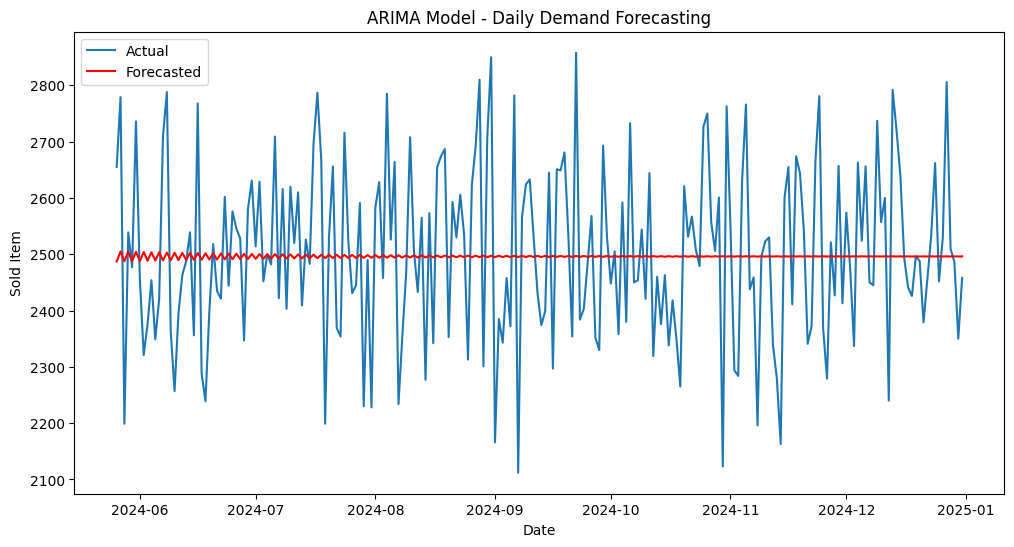

In [27]:
# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecasted', color='red')
plt.title('ARIMA Model - Daily Demand Forecasting')
plt.xlabel('Date')
plt.ylabel('Sold Item')
plt.legend()
plt.show()

In [31]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the parameter ranges
p = range(0, 3)  # AR terms
d = range(0, 2)  # Differencing
q = range(0, 3)  # MA terms
P = range(0, 3)  # Seasonal AR terms
D = range(0, 2)  # Seasonal differencing
Q = range(0, 3)  # Seasonal MA terms
s = [12]  # Seasonal period (e.g., 12 for monthly data)

# Generate all parameter combinations
param_grid = list(itertools.product(p, d, q, P, D, Q, s))

# Perform grid search
best_aic = float("inf")
best_params = None
best_model = None

for params in param_grid:
    try:
        # Unpack parameters
        p, d, q, P, D, Q, s = params

        # Fit SARIMAX model
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        results = model.fit()

        # Check AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
            best_model = results

    except Exception as e:
        # Skip combinations that fail
        continue

# Output the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)


Best Parameters: (0, 0, 2, 2, 0, 2, 12)
Best AIC: 14.0


In [32]:
forecast = best_model.forecast(steps=len(test))

In [33]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse}")

RMSE: 2508.4216723596605


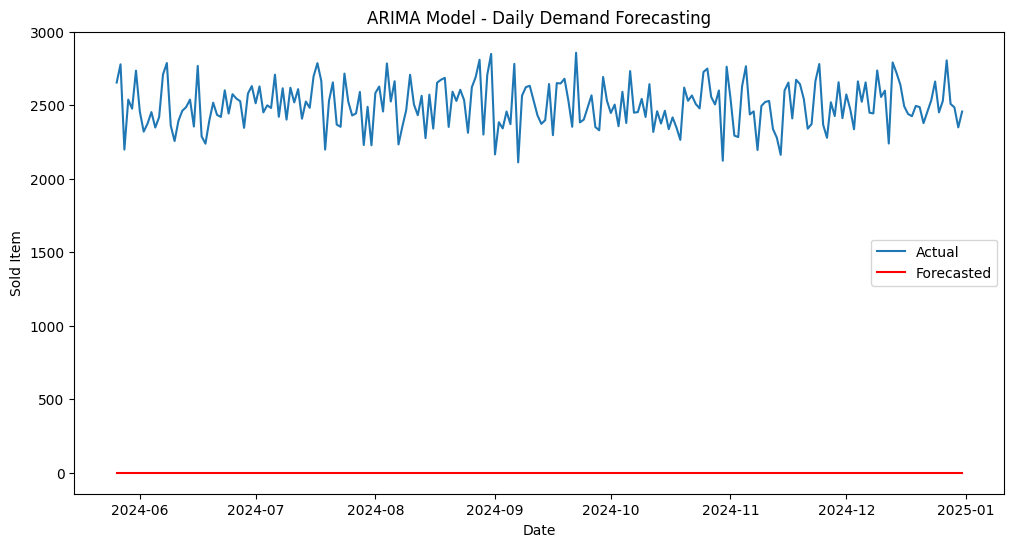

In [34]:
# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecasted', color='red')
plt.title('ARIMA Model - Daily Demand Forecasting')
plt.xlabel('Date')
plt.ylabel('Sold Item')
plt.legend()
plt.show()